# Translating by Prompting a LLM on the Importance of Parallel Data
Comparison of BLEU score achieved on the challenge set by an LLM and by mBART

## note : This is an assignment of course 'Mulitilinguality in NLP' at University of Paris Cité by professor M. Guillaume Wisniewski.

## Introduction
The aim of this lab is to test whether an LLM (a language model with many parameters learned from a large multilingual corpus) is capable of translating sentences and can be used in place of a specialized translation model (i.e. a model trained on a parallel corpus specifically designed to translate between two languages).
This can be done using so-called prompting methods, which simply involve (politely) asking the model to perform a task (in this case, translate a sentence).
You can look at the following article to see how Google researchers used their compa- ny’s LLM to translate texts : https://research.google/pubs/pub52543/.
Several Python libraries are now available for implementing prompting methods. A particularly fashionable library is langchain, but as the following example shows, it is also possible to use HuggingFace.

## Goal
We will use the challenge set available https://aclanthology.org/D17-1263/ to evaluate the capacity of a LLM to translate and compare their performance to mBART.



---



## Install

In [ ]:
!pip -q install git+https://github.com/huggingface/transformers
!pip install torch
!pip install accelerate
!pip install nltk
!pip install sentencepiece

In [ ]:
from nltk.translate import bleu
import json
import torch
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data : challenge set
Challenge is a set of difficult examples that are designed using expert linguistic knowl- edge to probe an MT system’s capabilities.
They are consists of short sentences that each focus on one particular phenomenon, which makes it easy to collect reliable manual assessments of MT out- put by asking direct yes-no questions. see figure below as an example.  

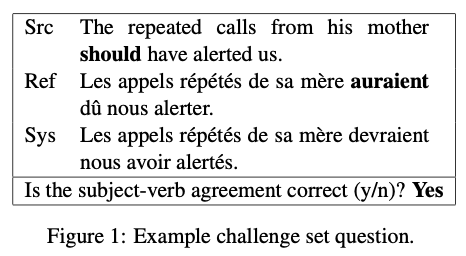

In [ ]:
import json
references = []
sources = []
translations = {'GNMT': [], 'PBMT1': [], 'PBMT2': [], 'NMT': []}
chall2score = {'Morpho-Syntactic': [], 'Lexico-Syntactic': [], 'Syntactic': []}

with open("/content/Challenge_set-v2hA.json", 'r') as file:
    for line in file:
      data = json.loads(line)
      references.append(data["reference"])
      sources.append(data["source"])
      for sys_content in data["systems"]:
        translations [sys_content["name"] ].append (sys_content["output"])
        chall2score[data['category_major']].append(sys_content["scores"])



references  = [ele.replace("[", "").replace("]", "") for ele in references] # erase crochets
# sources  = [ele.replace("[", "").replace("]", "") for ele in sources] # erase crochets


### proportion of correct translation

In [ ]:
# from itertools import chain
# for challenge in ['Morpho-Syntactic', 'Lexico-Syntactic', 'Syntactic']:
#   unzip = list(chain.from_iterable(chall2score[challenge]))
#   acc = unzip.count('Yes') / (len(unzip) - unzip.count('Not applicable'))
#   print( f"average score for {challenge} category : {round(acc,2)}")

average score for Morpho-Syntactic category : 0.47
average score for Lexico-Syntactic category : 0.46
average score for Syntactic category : 0.46


## prompting LLM : Flan T5

In [ ]:
from transformers import pipeline
import torch

def translate_LLM (sent):
  text2text_generator = pipeline("text2text-generation", model = 'google/flan-t5-base')
  prompt = "Translate from English to French: " + sent
  res = text2text_generator(prompt, max_length = 80)
  return res[0]["generated_text"]

### test llm

In [ ]:
LLM_trans = []
length = []
for src in sources :
  translated = translate_LLM(src)
  print(translated)
  LLM_trans.append(translated)


In [ ]:
with open("llm-res.txt", "w") as file:
  for i in range(len(LLM_trans)):
    file.write("S: "+ sources[i])
    file.write("\n")
    file.write("T: "+ LLM_trans[i])
    file.write("\n")


In [ ]:
LLM_trans  = [ele.replace("[", "").replace("]", "") for ele in LLM_trans] # erase crochets


## mbart

In [ ]:
!pip install transformers
!git clone https://github.com/google/sentencepiece.git
!cd sentencepiece
! mkdir build
! cd build
! cmake ..
! make -j $(nproc)
! sudo make install
! sudo ldconfig -v

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer.src_lang = "en_XX"
def translate_mbart(sentence):
  encoded_text = tokenizer(sentence, return_tensors="pt")
  generated_tokens = model.generate(**encoded_text, forced_bos_token_id=tokenizer.lang_code_to_id["fr_XX"])
  translated_sentence = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
  return translated_sentence


config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

ValueError: ignored

In [ ]:
# test = []
# for src in sources[:3] :
#   test += translate_mbart(src)
# test

In [ ]:
mbart_trans = []
for src in sources :
  mbart_trans += translate_mbart(src)

In [ ]:
mbart_trans  = [ele.replace("[", "").replace("]", "") for ele in mbart_trans] # erase crochets
references  = [ele.replace("[", "").replace("]", "") for ele in references] # erase crochets


In [ ]:
mbart_trans [:5]

['Les appels répétés de sa mère nous auraient dû alerter.',
 'Le bruit soudain dans les chambres supérieures nous aurait dû alerter.',
 'Leurs échecs répétés à signaler le problème auraient dû nous avertir.',
 'Elle a demandé à son frère de ne pas être arrogant.',
 'Elle a promis à son frère de ne pas être arrogant.']

In [ ]:
# with open("mbart_trans.txt", "w") as file:
#   for sent in mbart_trans :
#     file.write(str(sent)+"/n")

In [ ]:
# references

## BLEU metric

In [ ]:
!pip install sacrebleu

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import nltk.tokenize

def bleu(translations, references, language):
  tokenized_trans = [nltk.word_tokenize(sentence, language) for sentence in translations]
  tokenized_ref = [nltk.word_tokenize(sentence, language) for sentence in references]
  # Each reference translation should be in a list of lists
  score = corpus_bleu([[ref] for ref in tokenized_ref], tokenized_trans)
  # score = sentence_bleu(tokenized_ref, tokenized_trans)

  return round(score, 2)

In [ ]:
import sacrebleu

# Ensure that the number of translated sentences matches the number of reference sets
assert len(LLM_trans) == len(references)
zipped_references = list(zip(*references))
bleu = sacrebleu.corpus_bleu(LLM_trans, zipped_references)

print("BLEU score:", bleu.score)


BLEU score: 0.1178981761711091


### BLEU by Flan T5

In [ ]:
# for system_name in translations.keys() :
#   print(  f"{system_name} : {bleu (translations[system_name], references, 'french')}"  )

In [ ]:
print (bleu(LLM_trans, references,'french' ))

0.13


### BLEU by mbart

In [ ]:
# print (bleu(mbart_trans, references,'french' ))

0.45


In [ ]:
# print(mbart_trans, references, sep = '\n')

['Les appels répétés de sa mère nous auraient dû alerter.', 'Le bruit soudain dans les chambres supérieures nous aurait dû alerter.', 'Leurs échecs répétés à signaler le problème auraient dû nous avertir.', 'Elle a demandé à son frère de ne pas être arrogant.', 'Elle a promis à son frère de ne pas être arrogant.', 'Elle a promis à son médecin de rester active après sa retraite.', "Ma mère a promis à mon père d'être plus prudent sur la route.", 'La femme était très haute et extrêmement strong.', 'Leurs politiciens étaient plus ignorants que stupides.', 'Nous avons crié un insulte et nous sommes tombés abruptement.', 'Le chat et le chien devraient être surveillés.', 'Mon père et mon frère seront heureux demain.', 'Mon livre et mon stylo pourraient être volés.', 'La vache et la pomme de terre doivent être nourries.', 'Ma mère et ma sœur seront heureux demain.', 'Mes chaussures et mes chaussées seront trouvées.', 'Le chien et la vache sont nerveux.', 'Mon père et ma mère seront heureux dem

## Some error analysis on translation result of Flan T5

These are some interesting errors made by translation of Flan T5 . The corresponding english word are indicated in parentheses.
1. Some words are not translated ; the english term remained : tall (tall), strong(strong)
2. Some words are neither french nor english but other european languages like spanish, italien, etc : bédère (brother), séduqué(shouted), M'ami(my father), cibo (pencil)
3. Some are french words but not grammatical : M'ouvrage(my book)
4. Some 'fake' french words (looks like french in terms of orthography but it is not a real french) : lotteuse(lottery), savé(won), surprisés(surprised)

## Next question
Is it possible to compose prompt targeting these kinds of errors ?